In [16]:
#initial version
#created on 25.11.2020 by kaarel
#Idea to train and predict every SOURCE_KEY separately and build window features
#Inspired by https://www.kaggle.com/furiousx7/xgboost-time-series
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold

train_data = pd.read_csv('../Data/Train_Plant2_added_features.csv')


In [17]:
def create_features(in_data):
    in_data['DATE_TIME'] = pd.to_datetime(in_data['DATE_TIME'])
    in_data["DATE"] = in_data['DATE_TIME'].dt.date
    in_data["HOUR"] = in_data['DATE_TIME'].dt.hour
    in_data["MINUTE"] = in_data['DATE_TIME'].dt.minute
    in_data["DAY_OF_YEAR"] = in_data['DATE_TIME'].dt.dayofyear
    in_data["DAY_OF_WEEK"] = in_data['DATE_TIME'].dt.dayofweek
    in_data["MONTH"] = in_data['DATE_TIME'].dt.month
    in_data["DAY_OF_MONTH"] = in_data['DATE_TIME'].dt.day


train_columns = [
       'HOUR',
       'MINUTE',
       'DAY_OF_YEAR',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']


In [18]:
#
create_features(train_data)
split_date = pd.to_datetime('06-01-2020')
pred_train = train_data.loc[train_data.DATE <= split_date].copy()
pred_test = train_data.loc[train_data.DATE > split_date].copy()


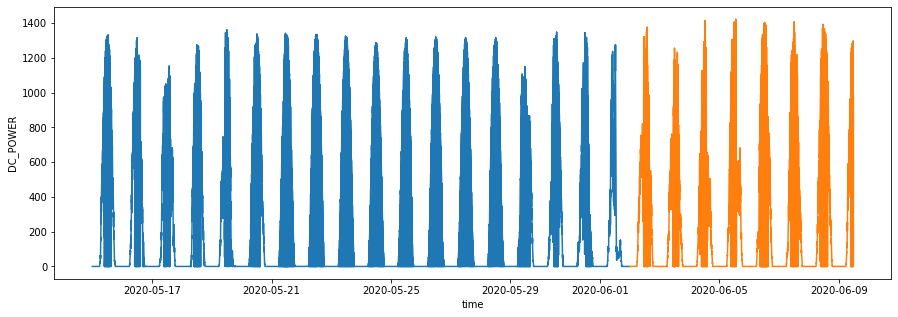

In [19]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('DC_POWER')
plt.plot(pred_train["DATE_TIME"],pred_train.DC_POWER)
plt.plot(pred_test["DATE_TIME"],pred_test.DC_POWER)
plt.show()

In [20]:
import numpy as np
predict_column = 'DC_POWER'
prediction_models = []
reg = xgb.XGBRegressor(n_estimators=10000)
reg.fit(pred_train[train_columns], pred_train[predict_column],
        eval_set=[(pred_train[train_columns], pred_train[predict_column]), (pred_test[train_columns], pred_test[predict_column])],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True)
prediction_models.append(reg)

[0]	validation_0-rmse:363.31155	validation_1-rmse:372.24383
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:301.83234	validation_1-rmse:337.89243
[2]	validation_0-rmse:265.20303	validation_1-rmse:326.77518
[3]	validation_0-rmse:243.90349	validation_1-rmse:319.76520
[4]	validation_0-rmse:232.00867	validation_1-rmse:312.74225
[5]	validation_0-rmse:220.87204	validation_1-rmse:310.01700
[6]	validation_0-rmse:215.04146	validation_1-rmse:313.78754
[7]	validation_0-rmse:211.73171	validation_1-rmse:317.62524
[8]	validation_0-rmse:207.45558	validation_1-rmse:313.81653
[9]	validation_0-rmse:202.47510	validation_1-rmse:313.31772
[10]	validation_0-rmse:200.27596	validation_1-rmse:313.34415
[11]	validation_0-rmse:197.91540	validation_1-rmse:313.09650
[12]	validation_0-rmse:196.89500	validation_1-rmse:313.31070
[13]	validation_0-rmse:193.08368	validation_1-rmse:313.798

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

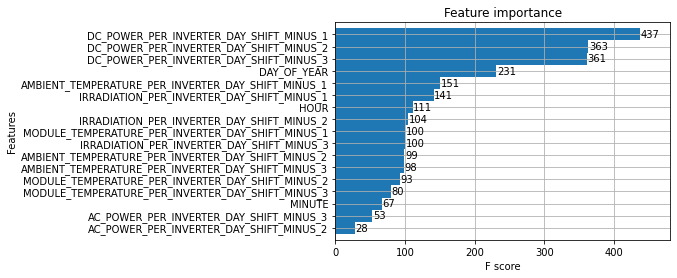

In [21]:
xgb.plot_importance(reg, height=1)

In [22]:
val_predictions = reg.predict(pred_test[train_columns])


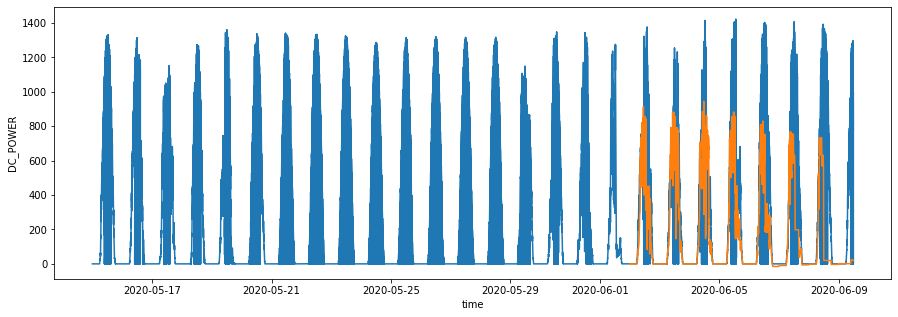

In [23]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('DC_POWER')
plt.plot(train_data["DATE_TIME"],train_data.DC_POWER)
plt.plot(pred_test["DATE_TIME"],val_predictions)
plt.show()

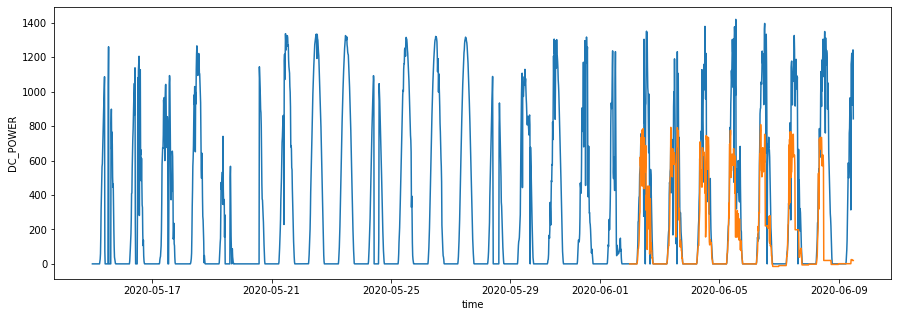

In [24]:
#SINGLE INVERTER

plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('DC_POWER')
plt.plot(train_data[train_data.SOURCE_KEY == '4UPUqMRk7TRMgml']["DATE_TIME"],train_data[train_data.SOURCE_KEY == '4UPUqMRk7TRMgml']["DC_POWER"])
plt.plot(pred_test[pred_test.SOURCE_KEY == '4UPUqMRk7TRMgml']["DATE_TIME"],reg.predict(pred_test[pred_test.SOURCE_KEY == '4UPUqMRk7TRMgml'][train_columns]))
plt.show()

In [25]:
#Features selection try all combinations in a set and choose best set
from itertools import combinations
def get_feature_set_rmse(train_columns):
    k = len(train_columns)-1
    print(k)
    new_train_columns = list(combinations(train_columns,k))
    prediction_models = []
    for t in new_train_columns:
        reg = xgb.XGBRegressor(n_estimators=10000)
        reg.fit(pred_train[np.asarray(t)], pred_train[predict_column],
            eval_set=[(pred_train[np.asarray(t)], pred_train[predict_column]), (pred_test[np.asarray(t)], pred_test[predict_column])],
            early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
            verbose=False)
        test_predictions = reg.predict(pred_test[np.asarray(t)])
        RMSE = mean_squared_error(pred_test[predict_column], test_predictions)
        prediction_models.append(RMSE)
        print(RMSE, t)
    return (prediction_models, new_train_columns)


In [26]:
#(models_performance, testes_features) = get_feature_set_rmse(train_columns)

In [27]:
best_models = []
initial_columns = train_columns.copy()
for k in np.arange(len(initial_columns),1,-1):
    (prediction_models, new_train_columns) = get_feature_set_rmse(initial_columns)
    current_loop_best = np.argmin(prediction_models)
    best_models.append((prediction_models[current_loop_best], new_train_columns[current_loop_best]))
    initial_columns = new_train_columns[current_loop_best]
    print('BEST:',prediction_models[current_loop_best],new_train_columns[current_loop_best])

16
94223.9246231268 ('HOUR', 'MINUTE', 'DAY_OF_YEAR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3')
92630.5927835018 ('HOUR', 'MINUTE', 'DAY_OF_YEAR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY_S

In [29]:
from calculate_model_statistics import calculate_RMSE_MSE


#PERFORMANCE VALIDATION ON TEST DATA
train_data = pd.read_csv('../Data/Train_Plant2_added_features.csv')
test_data = pd.read_csv('../Data/Test_Plant2_added_features.csv')
#BEST 1 plant model
#model_train_columns = ['HOUR', 'MINUTE', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']

#BEST 2 plant model
model_train_columns = ['HOUR', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1']

#DO DATA PREP FOR TRAIN
create_features(train_data)
split_date = pd.to_datetime('06-01-2020')
pred_train = train_data.loc[train_data.DATE <= split_date].copy()
pred_test = train_data.loc[train_data.DATE > split_date].copy()

#TRAIN BEST MODEL AGAIN
reg_final = xgb.XGBRegressor(n_estimators=10000)
reg_final.fit(pred_train[model_train_columns], pred_train[predict_column],
        eval_set=[(pred_train[model_train_columns], pred_train[predict_column]), (pred_test[model_train_columns], pred_test[predict_column])],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True)

#CREATE TEST_DATA FEATURES
create_features(test_data)

#DO TEST DATA PREDICTIONS
test_predictions = reg_final.predict(test_data[model_train_columns])

#INDIVIDUAL PERIODS PREDICTIONS
calculate_RMSE_MSE(test_data, predict_column, test_predictions)

[0]	validation_0-rmse:371.16928	validation_1-rmse:352.60693
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:317.57281	validation_1-rmse:304.43964
[2]	validation_0-rmse:287.23285	validation_1-rmse:279.51660
[3]	validation_0-rmse:270.64328	validation_1-rmse:267.29178
[4]	validation_0-rmse:261.97464	validation_1-rmse:261.93143
[5]	validation_0-rmse:257.06091	validation_1-rmse:259.81262
[6]	validation_0-rmse:254.64052	validation_1-rmse:258.77649
[7]	validation_0-rmse:253.27985	validation_1-rmse:258.94488
[8]	validation_0-rmse:252.27918	validation_1-rmse:259.08267
[9]	validation_0-rmse:251.55443	validation_1-rmse:259.35535
[10]	validation_0-rmse:251.03416	validation_1-rmse:260.06693
[11]	validation_0-rmse:250.38094	validation_1-rmse:260.16458
[12]	validation_0-rmse:249.86395	validation_1-rmse:260.18054
[13]	validation_0-rmse:249.70470	validation_1-rmse:260.521